# Introduction 
Submitted by: Susan Bataju 

["Chest X-Ray Images (Pneumonia)“](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) from Kaggle was chosen for Lab 2. The dataset contains 5863 OCT (Optical Coherence Tomography) and Chest X-ray validated images split into two categories (Pneumonia and Normal) selected from pediatric patients ranging from one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou [2].The dataset was first collected, organized, and analyzed in “Labeled Optical Coherence Topography (OCT) and Chest X-Ray Images for Classification” [1] by Kermany, D; Zhang, K et al. Images are labeled as (disease)-(randomized patient ID)-(image number by this patient). There are bacterial and viral pneumonia infections mixed in Pneumonia dataset.

The purpose of collecting this dataset is to detect pneumonia in patients using their chest X-Rays. A classifier with high accuracy which can detect pneumonia using X-Ray images will be revolutionary for doctors around the world. The uses of such a classifier can range from verifying doctors’ assignments to the reduction of their workload or use in remote places with fewer qualified human resources. 

Medical Industry will have major business interest in such a classifier. Someone’s life and well being might depend upon the accuracy of model as such it should have accuracy of greater than 98% but that is depended on use case. Even a few percentage of inaccuracy with largescale used can have adverisal effect on users. 

The images are of various sizes and aspect ratio. To make uniform sized images and avoid distortion like streching when changing the aspect ratio all the images are cropped. If the height of the image is greater than its width the top and the bottom portions of image are cropped by equal amount until the height and width are equal and when width is greater than height then the right and left portion are cropped. After the images are cropped they will have aspect ratio of 1 so that the images can be scaled without any distortions. Generally, the cropped image will contain most portion of lungs where as the empty part in left and right and head and lower portion of the images are cropped, retaining the most useful information. 

While all the images are gray scaled images, there are about 280 images in pneumonia images where the images are RBG, those images are transformed to grayscale images before use. 

PCA, Daisy and Gabor filter are test as methods of feature extraction. The performation of these methods are tested with a KNeighborsClassifier.  

In [5]:
import numpy as np
import pandas as pd
import glob 
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from copy import deepcopy
from skimage.transform import resize
from ipywidgets import widgets  # make this interactive!
import seaborn as sns
import copy

In [440]:
#using glob to get a list of all the jpeg files from the dataset.
train_norm = glob.glob("/Users/48391139/Downloads/chest_xray/train/NORMAL/*.jpeg")
train_pnom = glob.glob("/Users/48391139/Downloads/chest_xray/train/PNEUMONIA/*.jpeg")
test_norm = glob.glob("/Users/48391139/Downloads/chest_xray/test/NORMAL/*.jpeg")
test_pnom = glob.glob("/Users/48391139/Downloads/chest_xray/test/PNEUMONIA/*.jpeg")

In [457]:
#read the images using `matplotlib.image.imread`, save the name of the file and the image in a dictanary 
normal_image={}
normal_image_test={}
pneumonia_image={}
pneumonia_image_test={}

for count,img_file in  enumerate(train_norm):
    img = mpimg.imread(img_file)
    normal_image[img_file.split('/')[-1].split('.')[0]]=img

for count,img_file in  enumerate(test_norm):
    img = mpimg.imread(img_file)
    normal_image_test[img_file.split('/')[-1].split('.')[0]]=img

for img_file in  train_pnom:
    img = mpimg.imread(img_file)
    pneumonia_image[img_file.split('/')[-1].split('.')[0]]=img

for img_file in  test_pnom:
    img = mpimg.imread(img_file)
    pneumonia_image_test[img_file.split('/')[-1].split('.')[0]]=img

Following are the first few images in normal and pneumonia dataset. We can see that the images are not same size and aspect ratio.

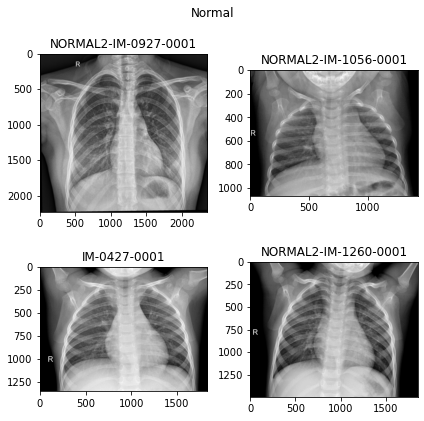

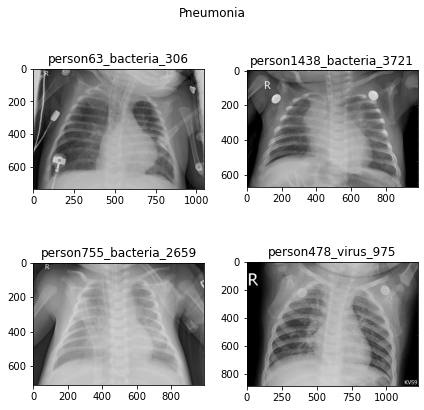

In [370]:
plt.figure(figsize=(6,6))
grid = 4
for count,(name,image) in enumerate(normal_image.items()):
    if count+1 > grid:continue
    lx,ly=image.shape
    if lx==ly:
        crop_image = Image.fromarray(image)
    X, Y = np.ogrid[0:lx, 0:ly]
    plt.subplot(int(grid/2), int(grid/2), count+1)
    tx,ty = np.shape(crop_image)
    plt.imshow(image,cmap='gray')
    plt.title(name)
plt.suptitle("Normal")

plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
for count,(name,image) in enumerate(pneumonia_image.items()):
    if count+1 > grid:continue
    lx,ly=image.shape
    if lx==ly:
        crop_image = Image.fromarray(image)
    X, Y = np.ogrid[0:lx, 0:ly]
    plt.subplot(int(grid/2), int(grid/2), count+1)
    tx,ty = np.shape(crop_image)
    plt.imshow(image,cmap='gray')
    plt.title(name)
plt.suptitle("Pneumonia")
plt.tight_layout()
plt.show()

Below is a large ~600 images grid in Normal dataset. They are croped as described in introduction.

In [4]:
plt.figure(figsize=(75,75))

col = 20
row = 20

for count,(name,image) in enumerate(normal_image.items()):
    if count+1 > row*col:continue
    lx,ly=image.shape
    if ly>lx: 
        crop_image = Image.fromarray(image).crop((math.floor(np.abs(ly-lx)/2),0,ly-math.floor(np.abs(ly-lx)/2),lx))
    if ly<lx:
        crop_image = Image.fromarray(image).crop((0,math.floor(np.abs(ly-lx)/2),ly,lx- math.floor(np.abs(ly-lx)/2)))
    if ly==lx:
        crop_image = Image.fromarray(image)
    plt.subplot(int(row), int(col), count+1)
    tx,ty = np.shape(crop_image)
    plt.imshow(np.asarray(crop_image),cmap='gray')
    plt.xticks(())
    plt.yticks(())
plt.suptitle("Normal",fontsize='xx-large')
plt.show()
 

NameError: name 'plt' is not defined

## Data Preparation and Resizing
Following code will crop the images and product a square images then are scaled as 120x120 images. RBG images are converted to grayscale images.

In [458]:
normal_image_resize = {}
for name,image in normal_image.items():
    lx,ly=image.shape
    if ly>lx: 
        crop_image = Image.fromarray(image).crop((math.floor(np.abs(ly-lx)/2),0,ly-math.floor(np.abs(ly-lx)/2),lx))
    if ly<lx:
        crop_image = Image.fromarray(image).crop((0,math.floor(np.abs(ly-lx)/2),ly,lx- math.floor(np.abs(ly-lx)/2)))
    if ly==lx:
        crop_image = Image.fromarray(image)
    image_resized = resize(np.asarray(crop_image), (120, 120),anti_aliasing=True)
    normal_image_resize[name] = image_resized
print("Normal Train Images import done.")
normal_image_resize_test = {}
for name,image in normal_image_test.items():
    lx,ly=image.shape
    if ly>lx: 
        crop_image = Image.fromarray(image).crop((math.floor(np.abs(ly-lx)/2),0,ly-math.floor(np.abs(ly-lx)/2),lx))
    if ly<lx:
        crop_image = Image.fromarray(image).crop((0,math.floor(np.abs(ly-lx)/2),ly,lx- math.floor(np.abs(ly-lx)/2)))
    if ly==lx:
        crop_image = Image.fromarray(image)
    image_resized = resize(np.asarray(crop_image), (120, 120),anti_aliasing=True)
    normal_image_resize_test[name] = image_resized

print("Normal Test Images import done.")

gray_scale_test={}
pneumonia_image_resize_test = {}
pneumonia_image_gray_test = {}
for name,image in pneumonia_image_test.items():
    if len(image.shape)==3:
        gray_scale_test[name]=image
    else:
        lx,ly=image.shape
        if ly>lx: 
            crop_image = Image.fromarray(image).crop((math.floor(np.abs(ly-lx)/2),0,ly-math.floor(np.abs(ly-lx)/2),lx))
        if ly<lx:
            crop_image = Image.fromarray(image).crop((0,math.floor(np.abs(ly-lx)/2),ly,lx- math.floor(np.abs(ly-lx)/2)))
        if ly==lx:
            crop_image = Image.fromarray(image)
    image_resized = resize(np.asarray(crop_image), (120, 120),anti_aliasing=True)
    pneumonia_image_resize_test[name] = image_resized
    pneumonia_image_gray_test[name]=image

print("Pneumonia Test Images import done.")


gray_scale={}
pneumonia_image_resize = {}
pneumonia_image_gray = {}

for name,image in pneumonia_image.items():
    if len(image.shape)==3:
        gray_scale[name]=image
    else:
        lx,ly=image.shape
        if ly>lx: 
            crop_image = Image.fromarray(image).crop((math.floor(np.abs(ly-lx)/2),0,ly-math.floor(np.abs(ly-lx)/2),lx))
        if ly<lx:
            crop_image = Image.fromarray(image).crop((0,math.floor(np.abs(ly-lx)/2),ly,lx- math.floor(np.abs(ly-lx)/2)))
        if ly==lx:
            crop_image = Image.fromarray(image)
    image_resized = resize(np.asarray(crop_image), (120, 120),anti_aliasing=True)
    pneumonia_image_resize[name] = image_resized
    pneumonia_image_gray[name]=image
print("Pneumonia Train Images import done.")

# Apply Gray Scale to RBG images and change rectangular sized images to square and uniform 120*120 pixel. Then add it back to all the other images.
for count,(name,image1) in enumerate(gray_scale.items()):
    b = image1.copy()
    # set green and red channels to 0
    b[:, :, 1] = 0
    b[:, :, 2] = 0
    g = image1.copy()
    # set blue and red channels to 0
    g[:, :, 0] = 0
    g[:, :, 2] = 0
    r = image1.copy()
    # set blue and green channels to 0
    r[:, :, 0] = 0
    r[:, :, 1] = 0
    image = 0.3*r[:, :, 2]+0.59*g[:, :, 1]+0.11*b[:, :, 0]

    lx,ly=image.shape
    if ly>lx: 
        crop_image = Image.fromarray(image).crop((math.floor(np.abs(ly-lx)/2),0,ly-math.floor(np.abs(ly-lx)/2),lx))
    if ly<lx:
        crop_image = Image.fromarray(image).crop((0,math.floor(np.abs(ly-lx)/2),ly,lx- math.floor(np.abs(ly-lx)/2)))
    if ly==lx:
        crop_image = Image.fromarray(image)
    image_resized = resize(np.asarray(crop_image), (120, 120),anti_aliasing=True)
    # added image back to same location
    pneumonia_image_resize[name] = image_resized  
    pneumonia_image_gray[name] = image  

for count,(name,image1) in enumerate(gray_scale_test.items()):
    b = image1.copy()
    # set green and red channels to 0
    b[:, :, 1] = 0
    b[:, :, 2] = 0
    g = image1.copy()
    # set blue and red channels to 0
    g[:, :, 0] = 0
    g[:, :, 2] = 0
    r = image1.copy()
    # set blue and green channels to 0
    r[:, :, 0] = 0
    r[:, :, 1] = 0
    image = 0.3*r[:, :, 2]+0.59*g[:, :, 1]+0.11*b[:, :, 0]

    lx,ly=image.shape
    if ly>lx: 
        crop_image = Image.fromarray(image).crop((math.floor(np.abs(ly-lx)/2),0,ly-math.floor(np.abs(ly-lx)/2),lx))
    if ly<lx:
        crop_image = Image.fromarray(image).crop((0,math.floor(np.abs(ly-lx)/2),ly,lx- math.floor(np.abs(ly-lx)/2)))
    if ly==lx:
        crop_image = Image.fromarray(image)
    image_resized = resize(np.asarray(crop_image), (120, 120),anti_aliasing=True)
    # added image back to same location
    pneumonia_image_resize_test[name] = image_resized  
    pneumonia_image_gray_test[name] = image  



Normal Train Images import done.
Normal Test Images import done.
Pneumonia Test Images import done.
Pneumonia Train Images import done.


Following are shows the final result of resizing and cropping on normal dataset.

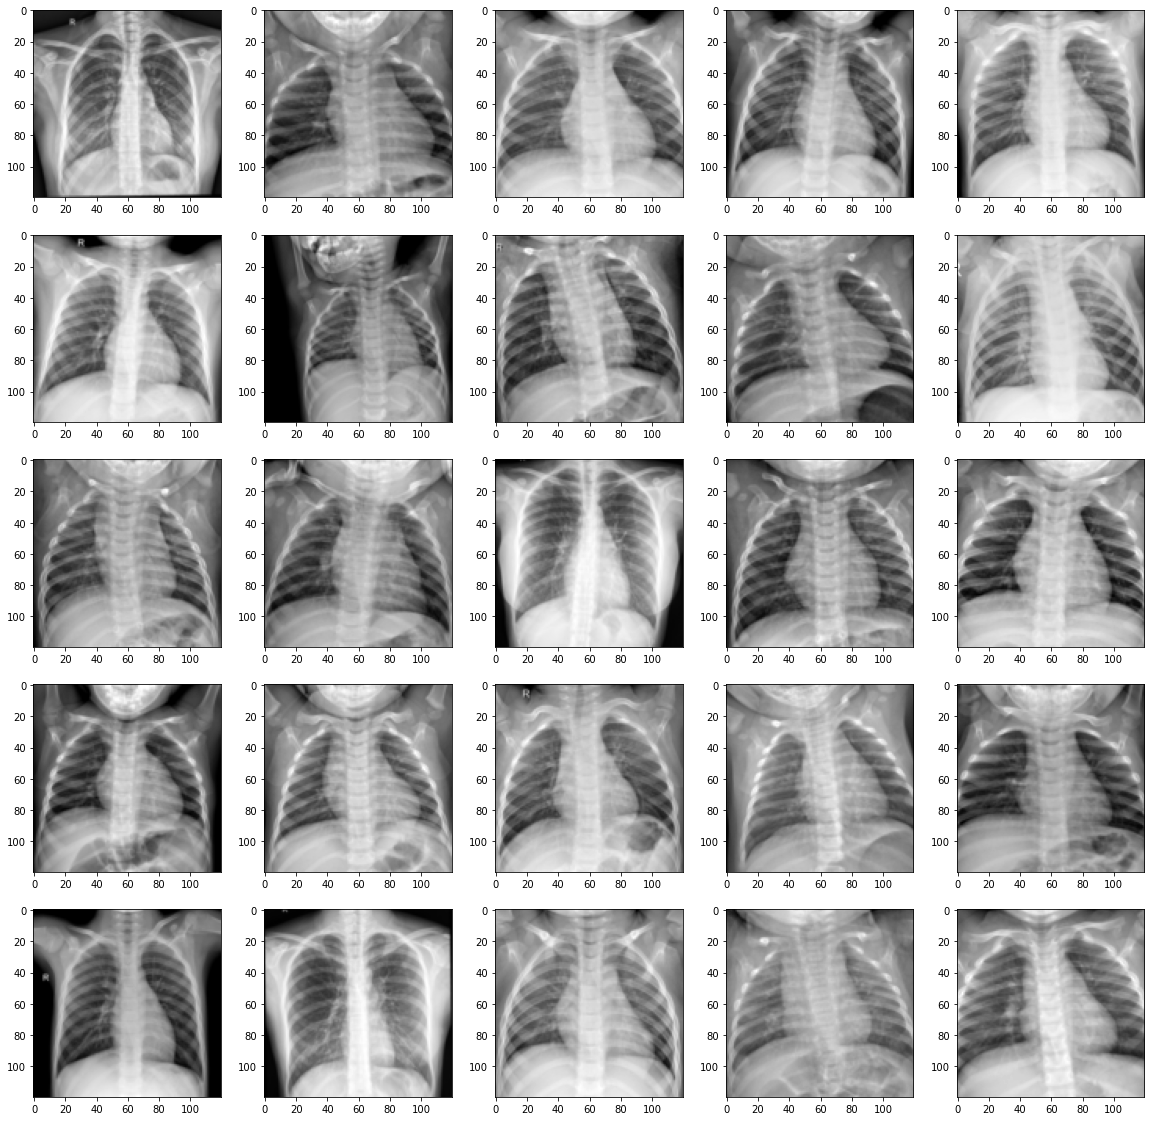

In [427]:

plt.figure(figsize=(20,20))
grid = 25
col = 5
for count,(name,image) in enumerate(normal_image.items()):
    if count+1 > grid:continue
    lx,ly=image.shape
    if ly>lx: 
        crop_image = Image.fromarray(image).crop((math.floor(np.abs(ly-lx)/2),0,ly-math.floor(np.abs(ly-lx)/2),lx))
    if ly<lx:
        crop_image = Image.fromarray(image).crop((0,math.floor(np.abs(ly-lx)/2),ly,lx- math.floor(np.abs(ly-lx)/2)))
    if ly==lx:
        crop_image = Image.fromarray(image)
    plt.subplot(int(grid/col), int(grid/col), count+1)
    image_resized = resize(np.asarray(crop_image), (120, 120),anti_aliasing=True)
    plt.imshow(image_resized,cmap='gray')
plt.show()


Following code show how the RGB images are converted to gray scale images.

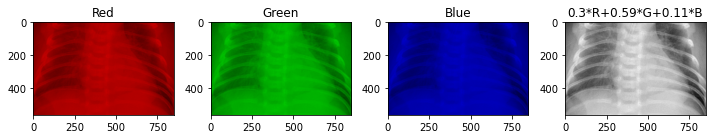

In [374]:
#https://stackoverflow.com/questions/44554125/python-want-to-display-red-channel-only-in-opencv
#https://saskeli.github.io/data-analysis-with-python-summer-2019/image_processing.html

plt.figure(figsize=(10,10))

firstimage = gray_scale[list(gray_scale.keys())[0]].copy()
# set   green and blue channels to 0
r = firstimage.copy()
r[:, :, 1] = 0
r[:, :, 2] = 0

g = firstimage.copy()
# set   blue and red channels to 0
g[:, :, 0] = 0
g[:, :, 2] = 0    

b = firstimage.copy()
# set red and green channels to 0
b[:, :, 0] = 0
b[:, :, 1] = 0 

# calculate the grayscale image pixel value from RGB values
gr1 = 0.3*r[:, :, 2]+0.59*g[:, :, 1]+0.11*b[:, :, 0]

plt.subplot(141)
plt.imshow(r)
plt.title("Red")
plt.subplot(142)
plt.imshow(g)
plt.title("Green")
plt.subplot(143)
plt.imshow(b)
plt.title("Blue")
plt.subplot(144)
plt.imshow(gr1,cmap=plt.cm.gray)
plt.title("0.3*R+0.59*G+0.11*B")

plt.tight_layout()
plt.show()


Before resizing and cropping the images, the following histogram show the distributing of original images. We should look are images which have high aspect ratio and make sure they are cropped properly.

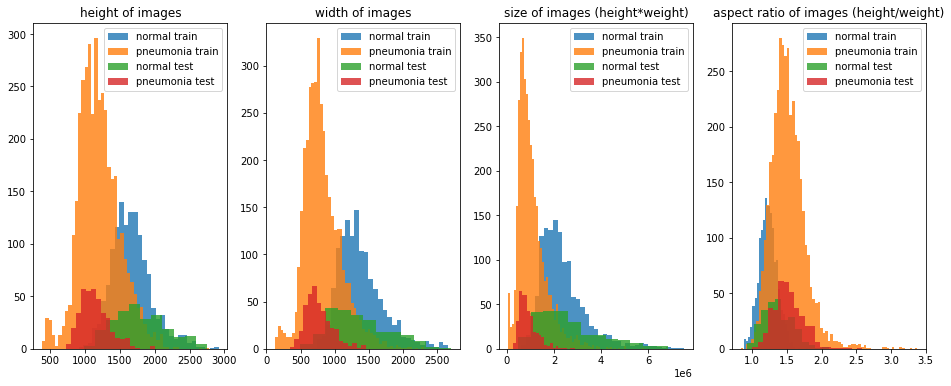

In [453]:
plt.figure(figsize=(16,6))
plt.subplot(141)
plt.hist(np.array([list(np.shape(i)) for i in normal_image.values()])[:,1],bins='auto',label='normal train',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in pneumonia_image_gray.values()])[:,1],bins='auto',label='pneumonia train',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in normal_image_test.values()])[:,1],bins='auto',label='normal test',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in pneumonia_image_gray_test.values()])[:,1],bins='auto',label='pneumonia test',alpha=0.8)
plt.title('height of images')
plt.legend()

plt.subplot(142)
plt.hist(np.array([list(np.shape(i)) for i in normal_image.values()])[:,0],bins='auto',label='normal train',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in pneumonia_image_gray.values()])[:,0],bins='auto',label='pneumonia train',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in normal_image_test.values()])[:,0],bins='auto',label='normal test',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in pneumonia_image_gray_test.values()])[:,0],bins='auto',label='pneumonia test',alpha=0.8)
plt.title('width of images')
plt.legend()

plt.subplot(143)
plt.hist(np.array([list(np.shape(i)) for i in normal_image.values()])[:,0]*np.array([list(np.shape(i)) for i in normal_image.values()])[:,1],bins='auto',label='normal train',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in pneumonia_image_gray.values()])[:,0]*np.array([list(np.shape(i)) for i in pneumonia_image_gray.values()])[:,1],bins='auto',label='pneumonia train',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in normal_image_test.values()])[:,0]*np.array([list(np.shape(i)) for i in normal_image_test.values()])[:,1],bins='auto',label='normal test',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in pneumonia_image_gray_test.values()])[:,0]*np.array([list(np.shape(i)) for i in pneumonia_image_gray_test.values()])[:,1],bins='auto',label='pneumonia test',alpha=0.8)
plt.title('size of images (height*weight)')
plt.legend()

plt.subplot(144)
plt.hist(np.array([list(np.shape(i)) for i in normal_image.values()])[:,1]/np.array([list(np.shape(i)) for i in normal_image.values()])[:,0],bins='auto',label='normal train',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in pneumonia_image_gray.values()])[:,1]/np.array([list(np.shape(i)) for i in pneumonia_image_gray.values()])[:,0],bins='auto',label='pneumonia train',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in normal_image_test.values()])[:,1]/np.array([list(np.shape(i)) for i in normal_image_test.values()])[:,0],bins='auto',label='normal test',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in pneumonia_image_gray_test.values()])[:,1]/np.array([list(np.shape(i)) for i in pneumonia_image_gray_test.values()])[:,0],bins='auto',label='pneumonia test',alpha=0.8)
plt.title('aspect ratio of images (height/weight)')
plt.legend()

plt.show()

As a basic image qualtity filter, looking at images with aspect ratio greater than 1.5 and height and width less than 600 pixels are all very zoomed and not sutiable for analysis. Those images are dropped.

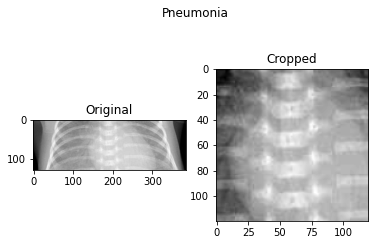

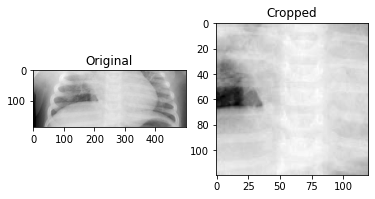

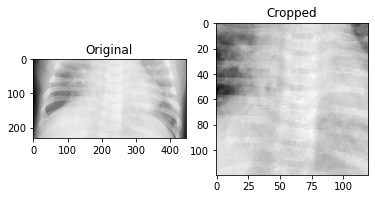

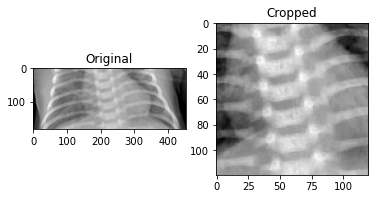

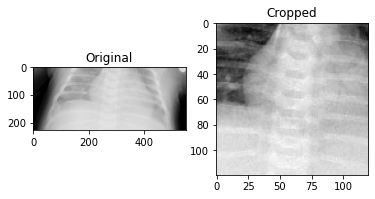

In [454]:
count =0
plt.figure()
plt.suptitle("Pneumonia")
for (name, image),(name1,image1) in zip(pneumonia_image_gray.items(),pneumonia_image_resize.items()):
    h,w = image.shape
    if w/h > 1.5 and 600 > w and 600 > h:
        if count>4: continue
        plt.subplot(121)
        plt.imshow(image,cmap='gray')
        plt.title("Original")
        plt.subplot(122)
        plt.imshow(image1,cmap='gray')
        plt.title("Cropped")
        plt.show()
        count+=1

Dropping the images with aspect ratio greater than 1.5 and height and width less than 600 pixels.

In [502]:

normal_image1 = [i for i in normal_image.keys() if normal_image[i].shape[1]/normal_image[i].shape[0] > 1.5 and normal_image[i].shape[0] < 600 and normal_image[i].shape[1] <600 ]
normal_image2 = [i for i in normal_image_test.keys() if normal_image_test[i].shape[1]/normal_image_test[i].shape[0] > 1.5 and normal_image_test[i].shape[0] < 600 and normal_image_test[i].shape[1] <600 ]
pneumonia_image_gray1 = [i for i in pneumonia_image_gray.keys() if (pneumonia_image_gray[i].shape[1]/pneumonia_image_gray[i].shape[0] > 1.5 and pneumonia_image_gray[i].shape[0] < 600 and pneumonia_image_gray[i].shape[1] <600 ) and pneumonia_image_gray[i].shape[1]/pneumonia_image_gray[i].shape[0] > 2 ]
pneumonia_image_gray2 = [i for i in pneumonia_image_gray_test.keys() if pneumonia_image_gray_test[i].shape[1]/pneumonia_image_gray_test[i].shape[0] > 1.5 and pneumonia_image_gray_test[i].shape[0] < 600 and pneumonia_image_gray_test[i].shape[1] <600 ]

normal_image_fil = normal_image.copy()
normal_image_test_fil=normal_image_test.copy()
pneumonia_image_gray_fil=pneumonia_image_gray.copy()
pneumonia_image_gray_test_fil = pneumonia_image_gray_test.copy()

for name  in normal_image1:
    del normal_image_fil[name]
    del normal_image_resize[name]

for name in normal_image2:
    del normal_image_test_fil[name]
    del normal_image_resize_test[name]

for name in pneumonia_image_gray1:
    del pneumonia_image_gray_fil[name]
    del pneumonia_image_resize[name]

for name in pneumonia_image_gray2:
    del pneumonia_image_gray_test_fil[name]
    del pneumonia_image_resize_test[name]
    
print(f'{len(normal_image1)} images removed from normal train')
print(f'{len(normal_image2)} images removed from normal test')
print(f'{len(pneumonia_image_gray1)} images removed from pneumonia train')
print(f'{len(pneumonia_image_gray2)} images removed from pneumonia test')


0 images removed from normal train
0 images removed from normal test
50 images removed from pneumonia train
0 images removed from pneumonia test


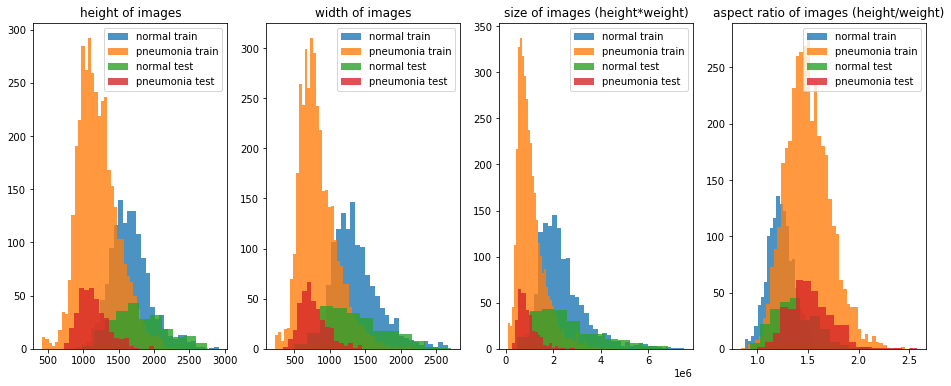

In [497]:
plt.figure(figsize=(16,6))
plt.subplot(141)
plt.hist(np.array([list(np.shape(i)) for i in normal_image_fil.values()])[:,1],bins='auto',label='normal train',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in pneumonia_image_gray_fil.values()])[:,1],bins='auto',label='pneumonia train',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in normal_image_test_fil.values()])[:,1],bins='auto',label='normal test',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in pneumonia_image_gray_test_fil.values()])[:,1],bins='auto',label='pneumonia test',alpha=0.8)
plt.title('height of images')
plt.legend()

plt.subplot(142)
plt.hist(np.array([list(np.shape(i)) for i in normal_image_fil.values()])[:,0],bins='auto',label='normal train',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in pneumonia_image_gray_fil.values()])[:,0],bins='auto',label='pneumonia train',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in normal_image_test_fil.values()])[:,0],bins='auto',label='normal test',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in pneumonia_image_gray_test_fil.values()])[:,0],bins='auto',label='pneumonia test',alpha=0.8)
plt.title('width of images')
plt.legend()

plt.subplot(143)
plt.hist(np.array([list(np.shape(i)) for i in normal_image_fil.values()])[:,0]*np.array([list(np.shape(i)) for i in normal_image_fil.values()])[:,1],bins='auto',label='normal train',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in pneumonia_image_gray_fil.values()])[:,0]*np.array([list(np.shape(i)) for i in pneumonia_image_gray_fil.values()])[:,1],bins='auto',label='pneumonia train',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in normal_image_test_fil.values()])[:,0]*np.array([list(np.shape(i)) for i in normal_image_test_fil.values()])[:,1],bins='auto',label='normal test',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in pneumonia_image_gray_test_fil.values()])[:,0]*np.array([list(np.shape(i)) for i in pneumonia_image_gray_test_fil.values()])[:,1],bins='auto',label='pneumonia test',alpha=0.8)
plt.title('size of images (height*weight)')
plt.legend()

plt.subplot(144)
plt.hist(np.array([list(np.shape(i)) for i in normal_image_fil.values()])[:,1]/np.array([list(np.shape(i)) for i in normal_image_fil.values()])[:,0],bins='auto',label='normal train',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in pneumonia_image_gray_fil.values()])[:,1]/np.array([list(np.shape(i)) for i in pneumonia_image_gray_fil.values()])[:,0],bins='auto',label='pneumonia train',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in normal_image_test_fil.values()])[:,1]/np.array([list(np.shape(i)) for i in normal_image_test_fil.values()])[:,0],bins='auto',label='normal test',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in pneumonia_image_gray_test_fil.values()])[:,1]/np.array([list(np.shape(i)) for i in pneumonia_image_gray_test_fil.values()])[:,0],bins='auto',label='pneumonia test',alpha=0.8)
plt.title('aspect ratio of images (height/weight)')
plt.legend()

plt.show()

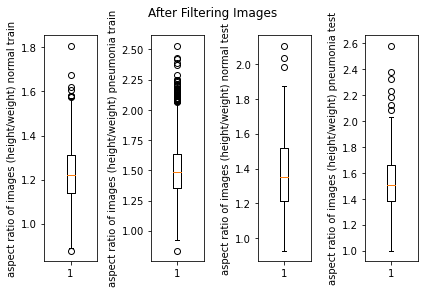

In [501]:
plt.subplot(141)
plt.suptitle("After Filtering Images")
plt.boxplot(np.array([list(np.shape(i)) for i in normal_image_fil.values()])[:,1]/np.array([list(np.shape(i)) for i in normal_image_fil.values()])[:,0])
plt.ylabel('aspect ratio of images (height/weight) normal train')

plt.subplot(142)
plt.boxplot(np.array([list(np.shape(i)) for i in pneumonia_image_gray_fil.values()])[:,1]/np.array([list(np.shape(i)) for i in pneumonia_image_gray_fil.values()])[:,0])
plt.ylabel('aspect ratio of images (height/weight) pneumonia train')
plt.subplot(143)
plt.boxplot(np.array([list(np.shape(i)) for i in normal_image_test_fil.values()])[:,1]/np.array([list(np.shape(i)) for i in normal_image_test_fil.values()])[:,0])
plt.ylabel('aspect ratio of images (height/weight) normal test')

plt.subplot(144)
plt.boxplot(np.array([list(np.shape(i)) for i in pneumonia_image_gray_test_fil.values()])[:,1]/np.array([list(np.shape(i)) for i in pneumonia_image_gray_test_fil.values()])[:,0])
plt.ylabel('aspect ratio of images (height/weight) pneumonia test')

plt.tight_layout()
plt.show()

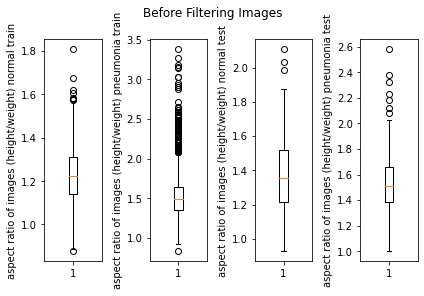

In [500]:
plt.subplot(141)
plt.suptitle("Before Filtering Images")

plt.boxplot(np.array([list(np.shape(i)) for i in normal_image.values()])[:,1]/np.array([list(np.shape(i)) for i in normal_image.values()])[:,0])
plt.ylabel('aspect ratio of images (height/weight) normal train')

plt.subplot(142)
plt.boxplot(np.array([list(np.shape(i)) for i in pneumonia_image_gray.values()])[:,1]/np.array([list(np.shape(i)) for i in pneumonia_image_gray.values()])[:,0])
plt.ylabel('aspect ratio of images (height/weight) pneumonia train')
plt.subplot(143)
plt.boxplot(np.array([list(np.shape(i)) for i in normal_image_test.values()])[:,1]/np.array([list(np.shape(i)) for i in normal_image_test.values()])[:,0])
plt.ylabel('aspect ratio of images (height/weight) normal test')

plt.subplot(144)
plt.boxplot(np.array([list(np.shape(i)) for i in pneumonia_image_gray_test.values()])[:,1]/np.array([list(np.shape(i)) for i in pneumonia_image_gray_test.values()])[:,0])
plt.ylabel('aspect ratio of images (height/weight) pneumonia test')

plt.tight_layout()
plt.show()

Here, looking at some images with aspect ratio great than 1.5, we see than, most of the image show significant portion of lungs. 

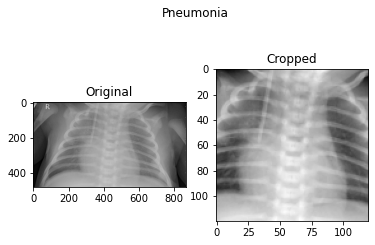

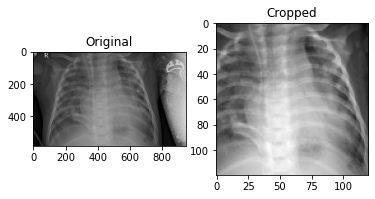

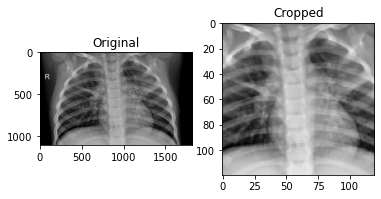

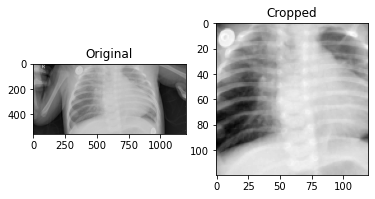

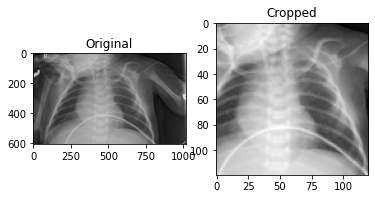

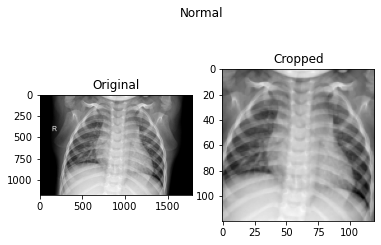

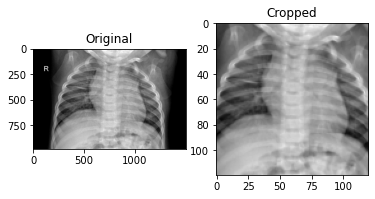

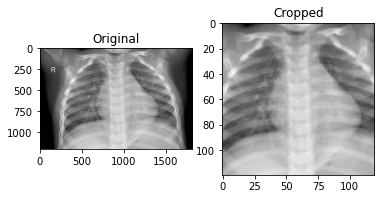

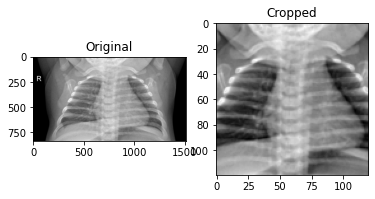

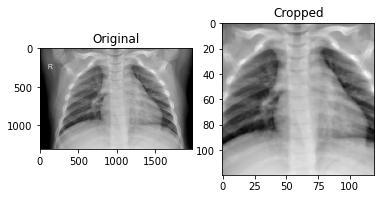

In [495]:
count =0
plt.figure()
plt.suptitle("Pneumonia")
for (name, image),(name1,image1) in zip(pneumonia_image_gray_fil.items(),pneumonia_image_resize.items()):
    h,w = image.shape
    if w/h > 1.5:
        if count>4: continue
        plt.subplot(121)
        plt.imshow(image,cmap='gray')
        plt.title("Original")
        plt.subplot(122)
        plt.imshow(image1,cmap='gray')
        plt.title("Cropped")
        plt.show()
        count+=1

count =0
plt.figure()
plt.suptitle("Normal")
for (name, image),(name1,image1) in zip(normal_image_fil.items(),normal_image_resize.items()):
    h,w = image.shape
    if w/h > 1.5:
        if count>4: continue
        plt.subplot(121)
        plt.imshow(image,cmap='gray')
        plt.title("Original")
        plt.subplot(122)
        plt.imshow(image1,cmap='gray')
        plt.title("Cropped")
        plt.show()
        count+=1

After resizing the images, we can see below that all the images are of same size and shape.

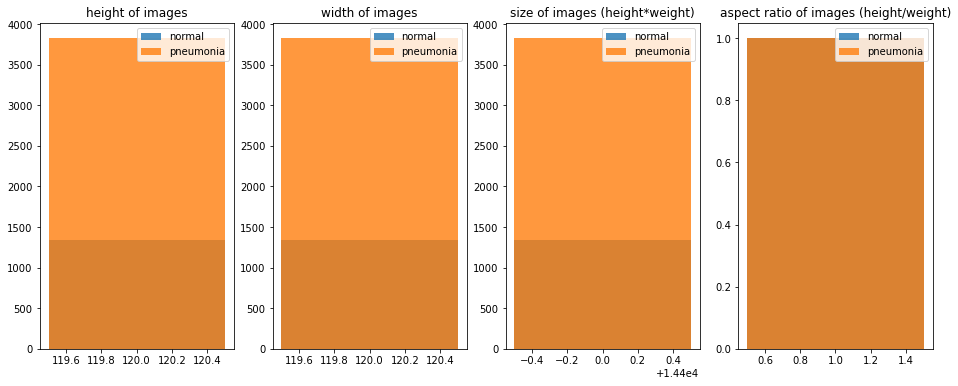

In [503]:
plt.figure(figsize=(16,6))
plt.subplot(141)
plt.hist(np.array([list(np.shape(i)) for i in normal_image_resize.values()])[:,1],bins='auto',label='normal',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in pneumonia_image_resize.values()])[:,1],bins='auto',label='pneumonia',alpha=0.8)
plt.title('height of images')
plt.legend()

plt.subplot(142)
plt.hist(np.array([list(np.shape(i)) for i in normal_image_resize.values()])[:,0],bins='auto',label='normal',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in pneumonia_image_resize.values()])[:,0],bins='auto',label='pneumonia',alpha=0.8)
plt.title('width of images')
plt.legend()

plt.subplot(143)
plt.hist(np.array([list(np.shape(i)) for i in normal_image_resize.values()])[:,0]*np.array([list(np.shape(i)) for i in normal_image_resize.values()])[:,1],bins='auto',label='normal',alpha=0.8)
plt.hist(np.array([list(np.shape(i)) for i in pneumonia_image_resize.values()])[:,0]*np.array([list(np.shape(i)) for i in pneumonia_image_resize.values()])[:,1],bins='auto',label='pneumonia',alpha=0.8)
plt.title('size of images (height*weight)')
plt.legend()

plt.subplot(144)
plt.hist(np.array([list(np.shape(i)) for i in normal_image_resize.values()])[:,1]/np.array([list(np.shape(i)) for i in normal_image_resize.values()])[:,0],bins='auto',label='normal',alpha=0.8,density=True)
plt.hist(np.array([list(np.shape(i)) for i in pneumonia_image_resize.values()])[:,1]/np.array([list(np.shape(i)) for i in pneumonia_image_resize.values()])[:,0],bins='auto',label='pneumonia',alpha=0.8,density=True)
plt.title('aspect ratio of images (height/weight)')
plt.legend()

plt.show()

Reshaping the image as (1,14400) shape vector i.e. rows in the images are joined together end to end into a siganl vector. Then the image vector,class and names are save in an array.

In [376]:
normal_reshape={}
_x= []
_y = []
_name = []
for count,(name, image) in enumerate(normal_image_resize.items()):
    
    if count ==1: i = image.copy()
    ivector = np.reshape(image,(1,120*120)).ravel()
    normal_reshape[name] = ivector
    _x.append(ivector)
    _y.append(0)
    _name.append(name)


pneumonia_reshape={}
for count,(name, image) in enumerate(pneumonia_image_resize.items()):
        ivector = np.reshape(image,(1,120*120)).ravel()
        pneumonia_reshape[name] = ivector
        _x.append(ivector)
        _y.append(1)
        _name.append(name)

normal_reshape_test={}
pneumonia_reshape_test={}
_xt,_yt,_namet=[],[],[]

for name,image in normal_image_resize_test.items():
    ivector = np.reshape(image,(1,120*120)).ravel()
    normal_reshape_test[name] = ivector
    _xt.append(ivector)
    _yt.append(0)
    _namet.append(name)
    
for name,image in pneumonia_image_resize_test.items():
    ivector = np.reshape(image,(1,120*120)).ravel()
    pneumonia_reshape_test[name] = ivector
    _xt.append(ivector)
    _yt.append(0)
    _namet.append(name)


Following shows all the images saved as a row vector each pixel is shown in x-axis and y-axis are different image samples 

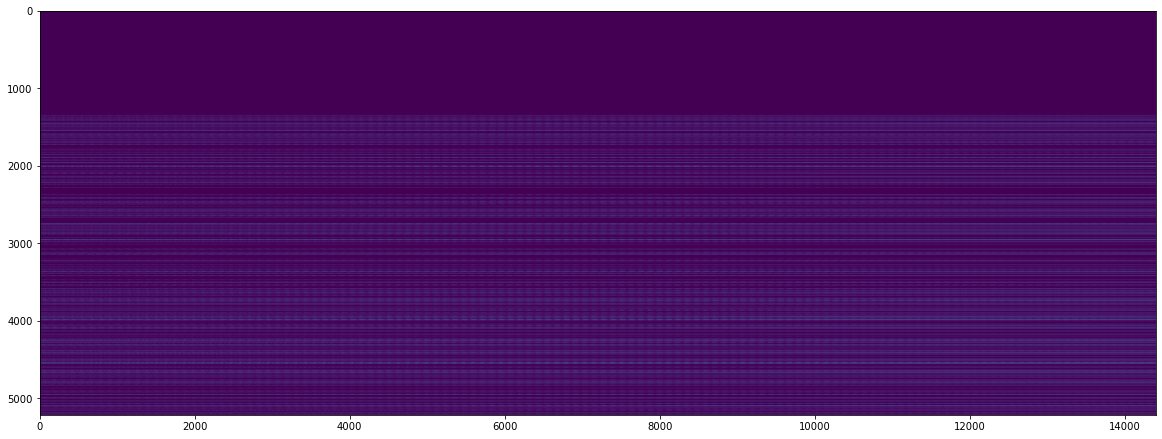

In [378]:
plt.figure(figsize=(20,20))
plt.imshow(_x)
plt.show()

We can get back the image if we reshape the row vector into (120,120) sized vector which is shown below.

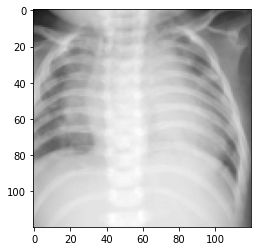

In [380]:
t = np.reshape(image,(1,120*120)).ravel()
plt.imshow(np.reshape(t,(120,120)),cmap='gray')
plt.show()


Now, make 2D arrays .

In [506]:
X = np.array(np.array(_x))
y = np.array(np.array(_y))
names = np.array(np.array(_name))

n_samples, n_features = X.shape
h, w = 120,120
n_classes = 2

print("number of infinte sample: ",np.sum(~np.isfinite(X)))
print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))
print(" Image Sizes {} by {} = {}".format(h,w,h*w))


number of infinte sample:  0
n_samples: 5216
n_features: 14400
n_classes: 2
 Image Sizes 120 by 120 = 14400


Let's test if standardizing the 2D array will have effect in later stages.

In [528]:
from sklearn.preprocessing import StandardScaler
X1 = X.copy()
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)

In [504]:

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def plot_explained_varieanc(pca,ndem):
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)

    plt.figure(figsize=[10,8])
    plt.bar([f'PCA{i+1}' for i in range(ndem)],explained_var[:ndem],label='individual explained variance')
    plt.plot([f'PCA{i+1}' for i in range(ndem)],cum_var_exp[:ndem],'or--',label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel("Principal components")
    plt.legend()
    plt.show()


## Data Reduction
Now, let's do PCA on the dataset. The code below is taken from Machien Learning Notebooks[[3].](https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb)

In [508]:
from sklearn.decomposition import PCA

n_components = 300
print ("Extracting the top %d eigenxray from %d x-ray" % (
    n_components, X.shape[0]))

pca = PCA(n_components=n_components)
pca.fit(X.copy())
eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 300 eigenxray from 5216 x-ray


The explained varience from one principal component is greater than 90% and captures most of the varience.

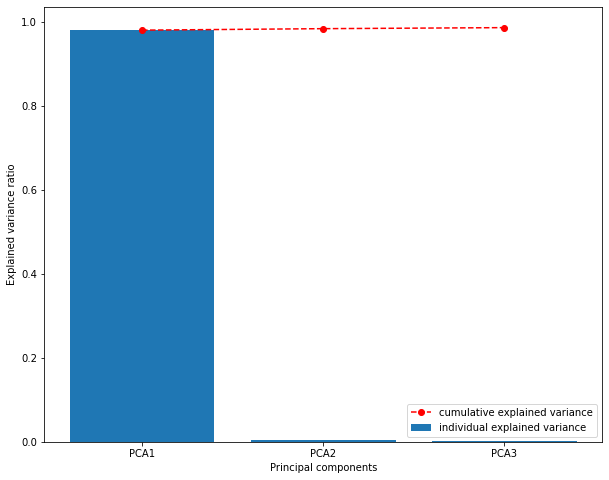

In [510]:
plot_explained_varieanc(pca,3)

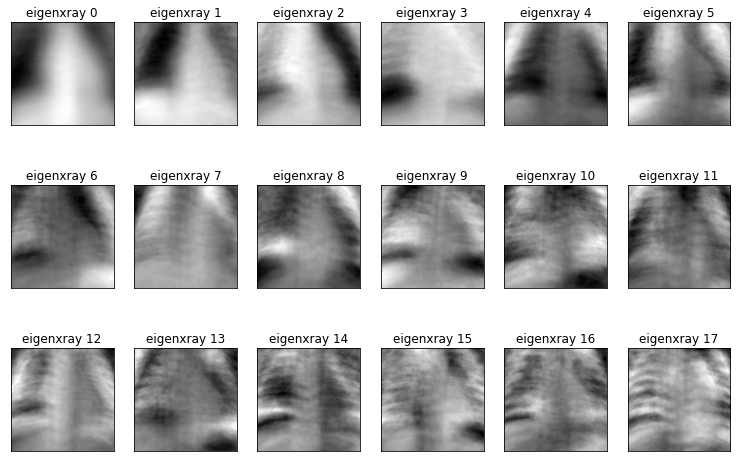

In [511]:
eigenface_titles = ["eigenxray %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

The eigenvector encode important features, on 1st to 11th "eigenxray" show location of lungs and heart and some ribs features, on 12th to 17th we can see the ribs as well.
Below we can see the last and first principal component with class label, 0 is normal and 1 is pneumonia. On the first principal component all the normal data point are less than 0.

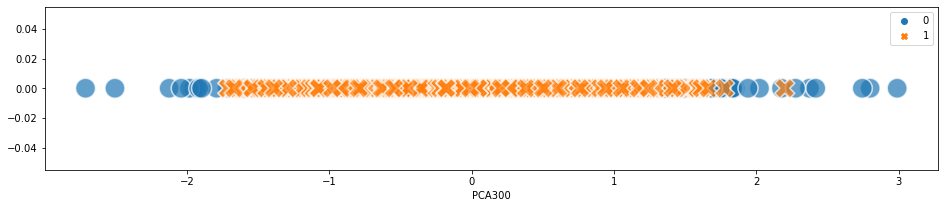

In [514]:
X_pca = pca.fit(X).transform(X)
plt.figure(figsize=(16,3))
sns.scatterplot(x=X_pca[:,299],y=np.zeros_like(X_pca[:,0]),hue=y,style=y,s=400,alpha=0.7)
plt.xlabel("PCA300")
plt.legend()
plt.show()

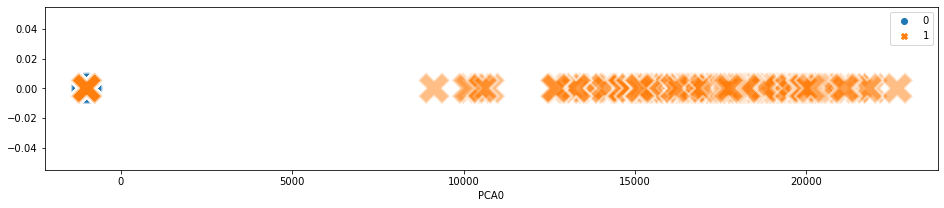

In [515]:
X_pca = pca.fit(X).transform(X)
plt.figure(figsize=(16,3))
sns.scatterplot(x=X_pca[:,0],y=np.zeros_like(X_pca[:,0]),hue=y,style=y,s=1000,alpha=0.5)
plt.xlabel("PCA0")
plt.legend()
plt.show()

In [108]:
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image
    
idx_to_reconstruct = 1    
X_idx = X[idx_to_reconstruct]
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X_idx.reshape(1, -1))

Now, let's show the low dimensional representation of the image give by the PCA. Note that, the location, intensity of color in lungs are seen but most of the detail we can see by eye is not present.

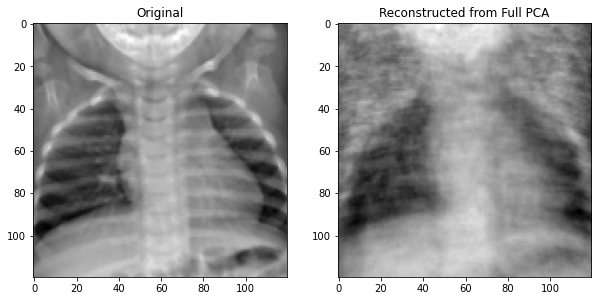

In [516]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(X_idx.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.grid(False)
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')
plt.grid(False)

Testing the stantarized 2D array.

Extracting the top 300 eigenxray from 5216 x-ray


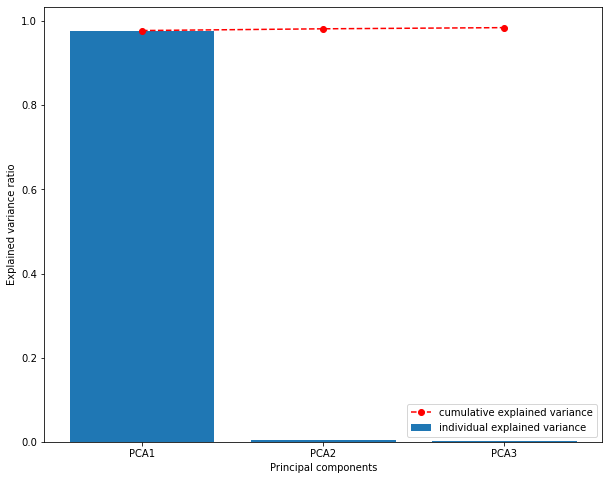

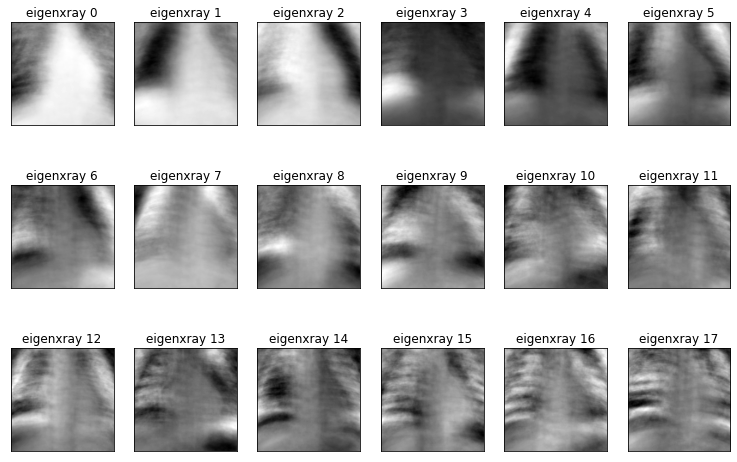

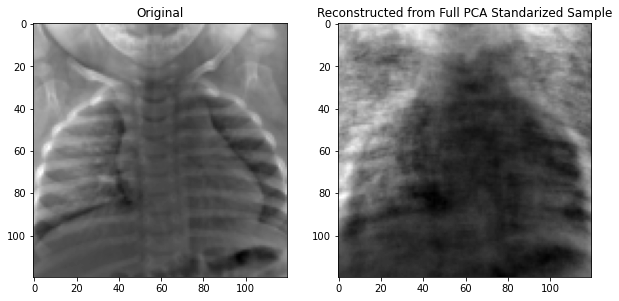

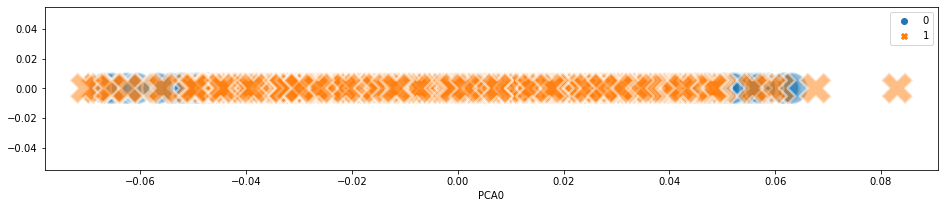

In [535]:
n_components = 300
print ("Extracting the top %d eigenxray from %d x-ray" % (
    n_components, X1.shape[0]))

pca1 = PCA(n_components=n_components)
pca1.fit(X1.copy())
eigenfaces1 = pca1.components_.reshape((n_components, h, w))
plot_explained_varieanc(pca1,3)
eigenface_titles1 = ["eigenxray %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces1, eigenface_titles1, h, w)
 
idx_to_reconstruct = 1    
X_idx = X1[idx_to_reconstruct]
low_dimensional_representation, reconstructed_image = reconstruct_image(pca1,X_idx.reshape(1, -1))
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(X_idx.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.grid(False)
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA Standarized Sample')
plt.grid(False)

X_pca = pca1.fit(X1).transform(X1)
plt.figure(figsize=(16,3))
sns.scatterplot(x=X_pca[:,299],y=np.zeros_like(X_pca[:,0]),hue=y,style=y,s=1000,alpha=0.5)
plt.xlabel("PCA0")
plt.legend()
plt.show()

It looks like standarizing the values changed the light color pixel more, like in 3rd eigenxray the light and dark are swapped and the final reconstructed image is darker as well. 

In [549]:
# lets do some randomizes PCA; full PCA tool 8.4s where as randomize PCA took 7.9. I will try to track the most time consuming processes. 

n_components = 300
print ("Extracting the top %d eigenfaces from %d faces" % (
    n_components, X.shape[0]))

rpca = PCA(n_components=n_components, svd_solver='randomized')
rpca.fit(X.copy())
eigenfaces = rpca.components_.reshape((n_components, h, w))

   
idx_to_reconstruct = 1    
X_idx = X1[idx_to_reconstruct]
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X_idx.reshape(1, -1))

Extracting the top 300 eigenfaces from 5216 faces


The eigenxrays are very simial to the full PCA and tells a similar story. Ribs are seen after 9th xray and lungs and heart is seen before them.

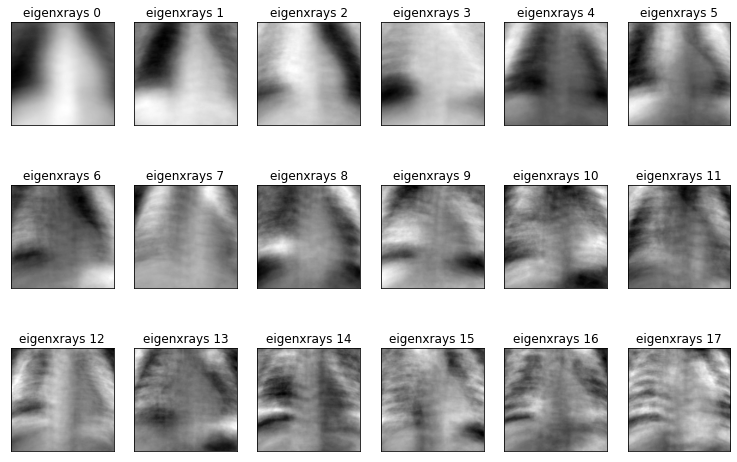

In [550]:
eigenface_titles = ["eigenxrays %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

Same conclusion as full PCA, most of the variance is defined by the first PCA.

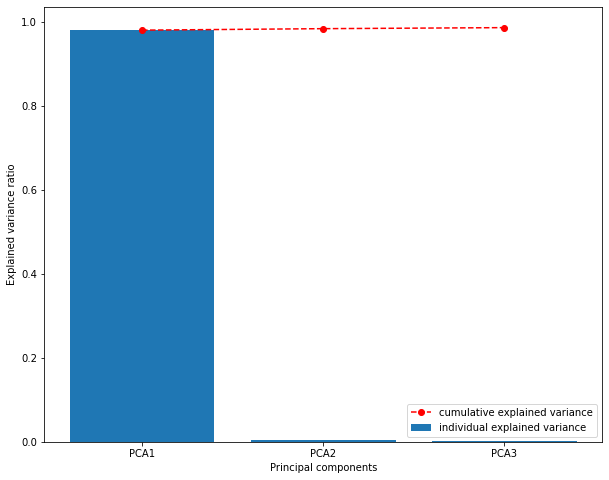

In [518]:
plot_explained_varieanc(rpca,3)

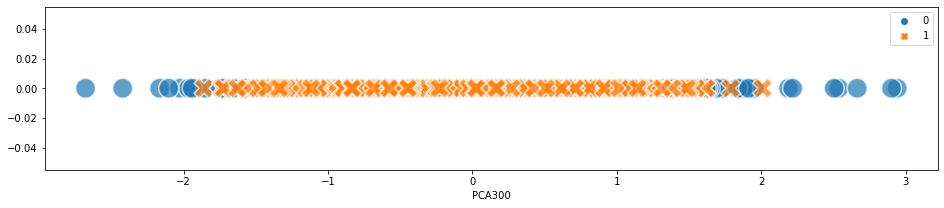

In [351]:
X_pca = rpca.fit(X).transform(X)
plt.figure(figsize=(16,3))
sns.scatterplot(x=X_pca[:,299],y=np.zeros_like(X_pca[:,0]),hue=y,style=y,s=400,alpha=0.7)
plt.xlabel("PCA300")
plt.legend()
plt.show()

Plot all the above reconstuction side by side.

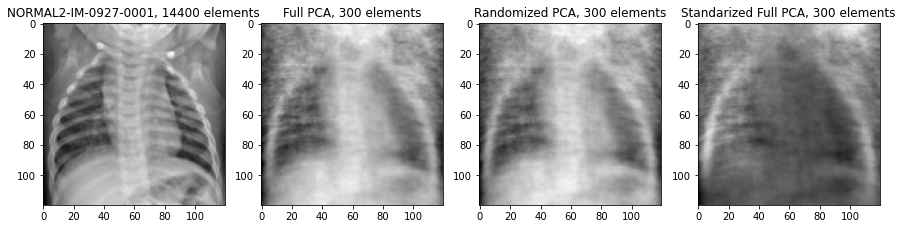

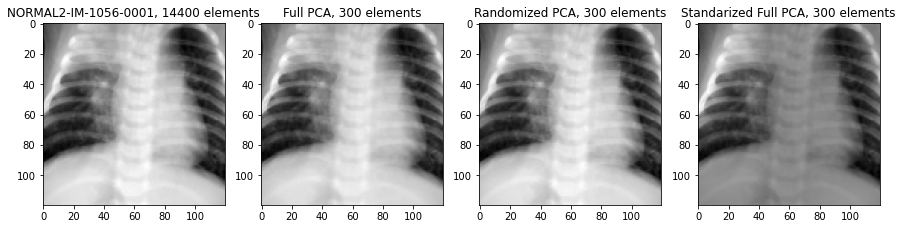

In [547]:
import warnings
# warnings.simplefilter('ignore', DeprecationWarning)
# warnings.simplefilter("always",DeprecationWarning)



def plt_reconstruct(idx_to_reconstruct):
    # this code is for reference only, it does not qualify as a neaarest neighbor search
    #  for your lab project. 
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    x_flat = X[idx_to_reconstruct].reshape(1, -1)
    x_flat1 = X1[idx_to_reconstruct].reshape(1, -1)

    reconstructed_image = pca.inverse_transform(pca.transform(x_flat.copy()))    
    reconstructed_image_s = pca1.inverse_transform(pca1.transform(x_flat1.copy()))    

    reconstructed_image_rpca = rpca.inverse_transform(rpca.transform(x_flat.copy()))
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,4,1) # original
    plt.imshow(x_flat.reshape((h, w)), cmap=plt.cm.gray)
    plt.title(names[y[idx_to_reconstruct]]+f", {x_flat.shape[1]} elements")
    plt.grid(False)
    
    plt.subplot(1,4,2) # pca
    plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title(f"Full PCA, {n_components} elements")
    plt.grid(False)
    
    plt.subplot(1,4,3) # randomized pca
    plt.imshow(reconstructed_image_rpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title(f"Randomized PCA, {n_components} elements")
    plt.grid(False)

    plt.subplot(1,4,4) # stantarized pca
    plt.imshow(reconstructed_image_s.reshape((h, w)), cmap=plt.cm.gray)
    plt.title(f"Standarized Full PCA, {n_components} elements")
    plt.grid(False)
    
    
    
plt_reconstruct(10)
plt_reconstruct(2220)

The randomized PCA and full PCA are both performing comparably, later we can see a small improvement in classifier accuracy if using full PCA. 

## Feature Extraction

Feature extraction on the dataset is done using DAISY. Three different architecture are considered.
- daisy: step=40, radius=16, rings=2, histograms=8, orientations=8,
- daisy1: step=30,radius=12,rings=2, histograms=6,orientations=8
- daisy2: step=24, radius=10, rings=2, histograms=8, orientations=8, 

and the image discription on the above architecture as shown below.

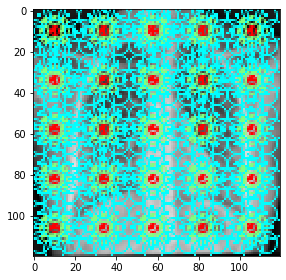

In [604]:
# daisy1
from skimage.feature import daisy
img  = X[0].reshape((h,w))
# lets first visualize what the daisy descriptor looks like
#since image is 120*120 some multiple of 12 in step seems appropriate


features, img_desc = daisy(img, 
                           step=24, 
                           radius=10, 
                           rings=2, 
                           histograms=8, 
                           orientations=8, 
                           visualize=True)
imshow(img_desc)
plt.grid(False)

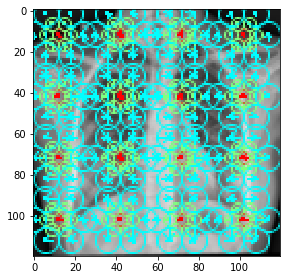

In [595]:
#daisy2
features, img_desc = daisy(img, 
                           step=30, 
                           radius=12, 
                           rings=2, 
                           histograms=6, 
                           orientations=8, 
                           visualize=True)
imshow(img_desc)
plt.grid(False)

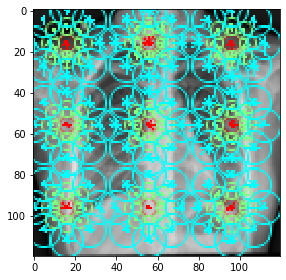

In [606]:
#daisy
features, img_desc = daisy(img, 
                           step=40, 
                           radius=16, 
                           rings=2, 
                           histograms=8, 
                           orientations=8, 
                           visualize=True)
imshow(img_desc)
plt.grid(False)

In [607]:
# create a function to take in the row of the matrix and return a new feature
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape), step=40, radius=16, 
                 rings=2, histograms=8, orientations=8, 
                 visualize=False)
    return feat.reshape((-1))



test_feature = apply_daisy(X[3],(h,w))
test_feature.shape

(1224,)

In [608]:
# apply to entire data, row by row,
# takes about a minute to run
daisy_features = np.apply_along_axis(apply_daisy, 1, X, (h,w))
print(daisy_features.shape)

(5216, 1224)


First, let's test the how will the full PCA, randomize PCA and daisy does with a KNeighborsClassifier. Two hyperparameters of the KNeighborsClassifier, n_neighnors(Number of neighbors to use ) and p(Power parameter for the Minkowski metric) is varied to find the most accuracy combination of hyperparameters. Number of neighbors is varied from 1 to 9 and p from 1,2 and 4.

In [626]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_rpca_features = rpca.transform(copy.deepcopy(X))
X_pca_features = pca.transform(copy.deepcopy(X))

pca_result={}
rpca_result={}
daisy_result={}


for n_neighnors in range(1,10):
    for p in [1,2,4]:
        print(f"working on n_neighnors {n_neighnors}, p {p}")
        # init a classifier for each feature space
        knn_pca = KNeighborsClassifier(n_neighbors=n_neighnors,p=p)
        knn_rpca = KNeighborsClassifier(n_neighbors=n_neighnors,p=p)
        knn_dsy = KNeighborsClassifier(n_neighbors=n_neighnors,p=p)

        # separate the data into train/test
        pca_train, pca_test,rpca_train,rpca_test, dsy_train, dsy_test, y_train, y_test = train_test_split(
            X_pca_features,X_rpca_features,daisy_features, y, test_size=0.2, train_size=0.8)

        # fit each classifier
        knn_pca.fit(pca_train,y_train)
        acc_pca = accuracy_score(knn_pca.predict(pca_test),y_test)
        pca_result[n_neighnors,p] = acc_pca

        knn_rpca.fit(rpca_train,y_train)
        acc_rpca = accuracy_score(knn_rpca.predict(rpca_test),y_test)
        rpca_result[n_neighnors,p] = acc_rpca
        knn_dsy.fit(dsy_train,y_train)
        acc_dsy = accuracy_score(knn_dsy.predict(dsy_test),y_test)
        daisy_result[n_neighnors,p] = acc_dsy

# report accuracy
# print(f"PCA accuracy:{100*acc_pca:.2f}%, RPCA accuracy:{100*acc_rpca:.2f}%  , Daisy Accuracy:{100*acc_dsy:.2f}%".format())

working on n_neighnors 1, p 1
working on n_neighnors 1, p 2
working on n_neighnors 1, p 4
working on n_neighnors 2, p 1
working on n_neighnors 2, p 2
working on n_neighnors 2, p 4
working on n_neighnors 3, p 1
working on n_neighnors 3, p 2
working on n_neighnors 3, p 4
working on n_neighnors 4, p 1
working on n_neighnors 4, p 2
working on n_neighnors 4, p 4
working on n_neighnors 5, p 1
working on n_neighnors 5, p 2
working on n_neighnors 5, p 4
working on n_neighnors 6, p 1
working on n_neighnors 6, p 2
working on n_neighnors 6, p 4
working on n_neighnors 7, p 1
working on n_neighnors 7, p 2
working on n_neighnors 7, p 4
working on n_neighnors 8, p 1
working on n_neighnors 8, p 2
working on n_neighnors 8, p 4
working on n_neighnors 9, p 1
working on n_neighnors 9, p 2
working on n_neighnors 9, p 4


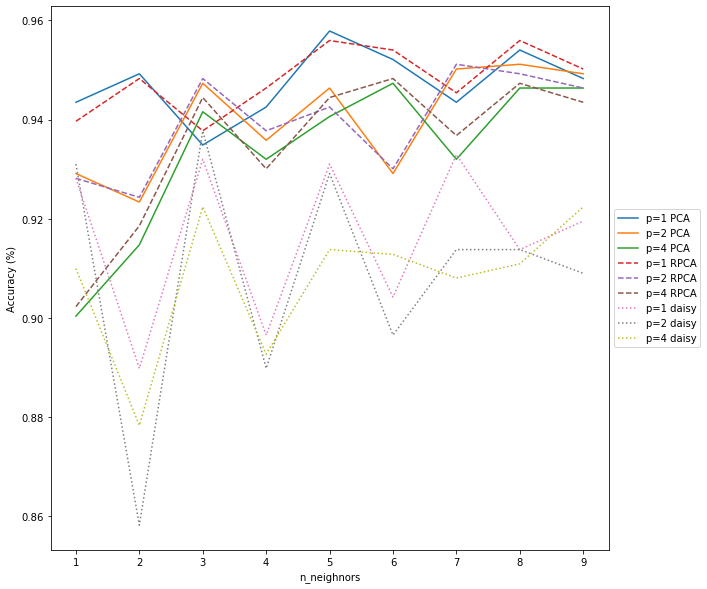

In [657]:
plt.figure(figsize=(10,10))
plt.plot(range(1,10),[pca_result[i,1] for i in range(1,10)],label=f'p=1 PCA')
plt.plot(range(1,10),[pca_result[i,2] for i in range(1,10)],label=f'p=2 PCA')
plt.plot(range(1,10),[pca_result[i,4] for i in range(1,10)],label=f'p=4 PCA')

plt.plot(range(1,10),[rpca_result[i,1] for i in range(1,10)],label=f'p=1 RPCA',linestyle='dashed')
plt.plot(range(1,10),[rpca_result[i,2] for i in range(1,10)],label=f'p=2 RPCA',linestyle='dashed')
plt.plot(range(1,10),[rpca_result[i,4] for i in range(1,10)],label=f'p=4 RPCA',linestyle='dashed')

plt.plot(range(1,10),[daisy_result[i,1] for i in range(1,10)],label=f'p=1 daisy',linestyle='dotted')
plt.plot(range(1,10),[daisy_result[i,2] for i in range(1,10)],label=f'p=2 daisy',linestyle='dotted')
plt.plot(range(1,10),[daisy_result[i,4] for i in range(1,10)],label=f'p=4 daisy',linestyle='dotted')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("n_neighnors")
plt.ylabel("Accuracy (%)")

plt.show()


We can see that full PCA and randomized PCA are much more accurate than Daisy mode. Furthermore, with  Number of neighbors as 5 and p as 1, gives the most accurate results. We can see full PCA and randomized PCA are performing is same rate but full PCA is slightly better.

Following is the confusion matrix for the best performing model (full PCA with n_neighbors=5 and p=1). Note: the model accuracy flucates a bit. 

In [708]:
from sklearn.metrics import confusion_matrix
knn_pca = KNeighborsClassifier(n_neighbors=5,p=1)
pca_train, pca_test, y_train, y_test = train_test_split(X_pca_features, y, test_size=0.2, train_size=0.8)
knn_pca.fit(pca_train,y_train)
print(accuracy_score(knn_pca.predict(pca_test),y_test))
print(confusion_matrix(y_test,knn_pca.predict(pca_test)))
tn, fp =confusion_matrix(y_test,knn_pca.predict(pca_test))
print(f" True negetive {tn[0]}, false postive {tn[1]}, false negetive {fp[0]}, true prostive {fp[1]} ")

0.9415708812260536
[[248  41]
 [ 20 735]]
 True negetive 248, false postive 41, false negetive 20, true prostive 735 


In the following code 

In [658]:
# create a function to take in the row of the matrix and return a new feature
def apply_daisy1(row,shape):
    feat = daisy(row.reshape(shape), step=30, radius=12, 
                 rings=2, histograms=6, orientations=8, 
                 visualize=False)
    return feat.reshape((-1))

daisy_features1 = np.apply_along_axis(apply_daisy1, 1, X, (h,w))

def apply_daisy2(row,shape):
    feat = daisy(row.reshape(shape), step=24, radius=10, 
                 rings=2, histograms=8, orientations=8, 
                 visualize=False)
    return feat.reshape((-1))

daisy_features2 = np.apply_along_axis(apply_daisy2, 1, X, (h,w))




In [659]:
daisy_result1 ={}
daisy_result2 ={}

for n_neighnors in range(1,10):
    for p in [1,2,4]:
        print(f"working on n_neighnors {n_neighnors}, p {p}")
        # init a classifier for each feature space

        knn_dsy1 = KNeighborsClassifier(n_neighbors=n_neighnors,p=p)
        knn_dsy2 = KNeighborsClassifier(n_neighbors=n_neighnors,p=p)

        # separate the data into train/test
        dsy_train1, dsy_test1,dsy_train2, dsy_test2, y_train, y_test = train_test_split(
            daisy_features1,daisy_features2, y, test_size=0.2, train_size=0.8)
        knn_dsy1.fit(dsy_train1,y_train)
        acc_dsy1 = accuracy_score(knn_dsy1.predict(dsy_test1),y_test)
        daisy_result1[n_neighnors,p] = acc_dsy1
        knn_dsy2.fit(dsy_train2,y_train)
        acc_dsy2 = accuracy_score(knn_dsy2.predict(dsy_test2),y_test)
        daisy_result2[n_neighnors,p] = acc_dsy2

working on n_neighnors 1, p 1
working on n_neighnors 1, p 2
working on n_neighnors 1, p 4
working on n_neighnors 2, p 1
working on n_neighnors 2, p 2
working on n_neighnors 2, p 4
working on n_neighnors 3, p 1
working on n_neighnors 3, p 2
working on n_neighnors 3, p 4
working on n_neighnors 4, p 1
working on n_neighnors 4, p 2
working on n_neighnors 4, p 4
working on n_neighnors 5, p 1
working on n_neighnors 5, p 2
working on n_neighnors 5, p 4
working on n_neighnors 6, p 1
working on n_neighnors 6, p 2
working on n_neighnors 6, p 4
working on n_neighnors 7, p 1
working on n_neighnors 7, p 2
working on n_neighnors 7, p 4
working on n_neighnors 8, p 1
working on n_neighnors 8, p 2
working on n_neighnors 8, p 4
working on n_neighnors 9, p 1
working on n_neighnors 9, p 2
working on n_neighnors 9, p 4


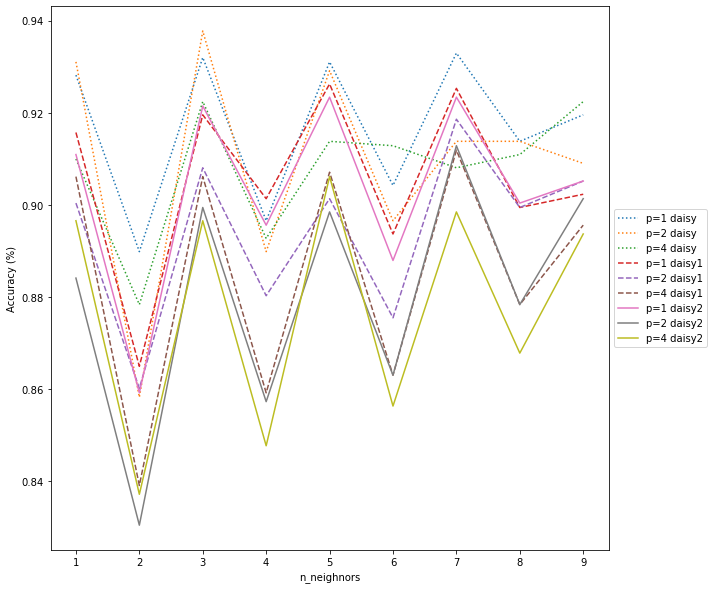

In [660]:
plt.figure(figsize=(10,10))

plt.plot(range(1,10),[daisy_result[i,1] for i in range(1,10)],label=f'p=1 daisy',linestyle='dotted')
plt.plot(range(1,10),[daisy_result[i,2] for i in range(1,10)],label=f'p=2 daisy',linestyle='dotted')
plt.plot(range(1,10),[daisy_result[i,4] for i in range(1,10)],label=f'p=4 daisy',linestyle='dotted')

plt.plot(range(1,10),[daisy_result1[i,1] for i in range(1,10)],label=f'p=1 daisy1',linestyle='dashed')
plt.plot(range(1,10),[daisy_result1[i,2] for i in range(1,10)],label=f'p=2 daisy1',linestyle='dashed')
plt.plot(range(1,10),[daisy_result1[i,4] for i in range(1,10)],label=f'p=4 daisy1',linestyle='dashed')

plt.plot(range(1,10),[daisy_result2[i,1] for i in range(1,10)],label=f'p=1 daisy2')
plt.plot(range(1,10),[daisy_result2[i,2] for i in range(1,10)],label=f'p=2 daisy2')
plt.plot(range(1,10),[daisy_result2[i,4] for i in range(1,10)],label=f'p=4 daisy2')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("n_neighnors")
plt.ylabel("Accuracy (%)")

plt.show()

We can see if the rings are seperated and sparse the Daisy seem to perform better than have a lot of rings.

Now, matching the total Daisy vectors which gives the following results. It is selecting images which do look similar by eye as seen below.

In [669]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
dist_matrix = pairwise_distances(daisy_features)

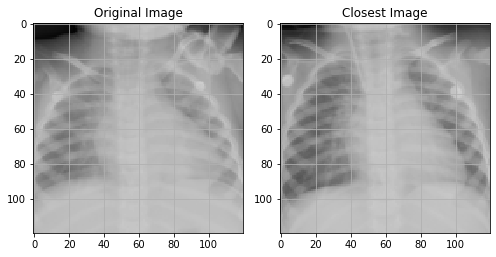

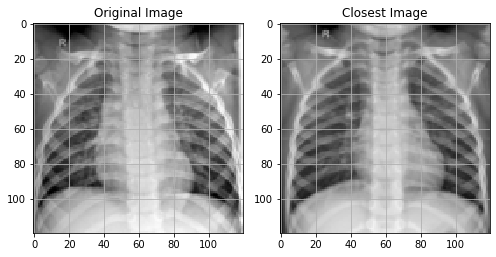

In [678]:
import copy
# find closest image to current image
idx1 = 5100
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
imshow(X[idx1].reshape((h,w)))
plt.title("Original Image")
plt.grid()

plt.subplot(1,2,2)
imshow(X[idx2].reshape((h,w)))
plt.title("Closest Image")
plt.grid()

# find closest image to current image
idx1 = 100
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
imshow(X[idx1].reshape((h,w)))
plt.title("Original Image")
plt.grid()

plt.subplot(1,2,2)
imshow(X[idx2].reshape((h,w)))
plt.title("Closest Image")
plt.grid()

And the following image matching comparision between randomized PCA vs daisy 

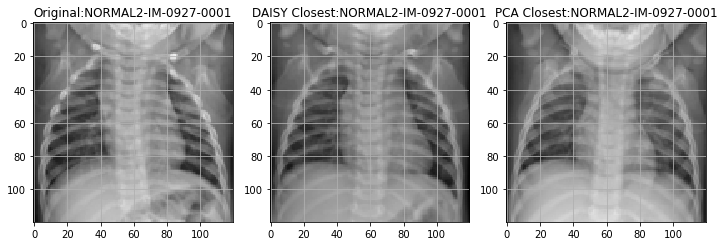

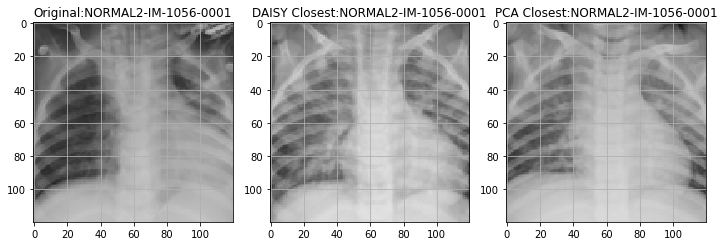

In [681]:
from ipywidgets import fixed
import copy

from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features

X_pca_features = rpca.transform(copy.deepcopy(X))
dist_matrix_pca = pairwise_distances(copy.deepcopy(X_pca_features),
                                     metric="seuclidean")

# put it together inside a nice widget
def closest_image(dmat_daisy, dmat_pca, idx1):
    # NOTE: this will not suffice for evaluation 
    # of a nearest neighbor classifier for your lab assignment
    # do not use this code for satifying the lab assignment requirement
    
    distances = copy.deepcopy(dmat_daisy[idx1,:]) # get all image diatances
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    
    distances = copy.deepcopy(dmat_pca[idx1,:]) # get all image diatances
    distances[idx1] = np.infty # dont pick the same image!
    idx3 = np.argmin(distances)
    
    plt.figure(figsize=(10,16))
    plt.subplot(1,3,1)
    imshow(X[idx1].reshape((h,w)))
    plt.title("Original:"+names[y[idx1]])
    plt.grid()

    plt.subplot(1,3,2)
    imshow(X[idx2].reshape((h,w)))
    plt.title("DAISY Closest:"+names[y[idx2]])
    plt.grid()
    
    plt.subplot(1,3,3)
    imshow(X[idx3].reshape((h,w)))
    plt.title("PCA Closest:"+names[y[idx3]])
    plt.grid()
    
closest_image(dist_matrix,dist_matrix_pca,10)
closest_image(dist_matrix,dist_matrix_pca,5210)


Just to test the keypoint matching function.

In [687]:
from skimage.feature import match_descriptors

def apply_daisy(row,shape): # no reshape in this function
    feat = daisy(row.reshape(shape), step=40, radius=16, 
                 rings=2, histograms=8, orientations=8, 
                 visualize=False)
    s = feat.shape # PxQxR
    #P = ceil((Height - radius*2) / step) 
    #Q = ceil((Width - radius*2) / step) 
    #R = (rings * histograms + 1) * orientations
    return feat.reshape((s[0]*s[1],s[2]))

d1 = apply_daisy(X[10],(h,w))
d2 = apply_daisy(X[11],(h,w))
d3 = apply_daisy(X[5000],(h,w))

print(d1.shape, d2.shape, d3.shape)
print('Classes:',y[10],y[11],y[5000])

# return list of the key points indices that matched closely enough
matches = match_descriptors(d1, d2, cross_check=True, max_ratio=0.8)
print(f"Number of matches, same class: {matches.shape[0]}, Percentage:{100*matches.shape[0]/len(d1):0.2f}%")

# return list of the key points indices that matched closely enough
matches = match_descriptors(d1, d3, cross_check=True, max_ratio=0.8)
print(f"Number of matches, diff classes: {matches.shape[0]}, Percentage:{100*matches.shape[0]/len(d1):0.2f}%")

(9, 136) (9, 136) (9, 136)
Classes: 0 0 1
Number of matches, same class: 4, Percentage:44.44%
Number of matches, diff classes: 4, Percentage:44.44%


In [743]:
#Keypoint Matching just doing 4 image (2 top images and 2 bottom) takes about 35 mins. 

def apply_daisy(row,shape): # no reshape in this function
    feat = daisy(row.reshape(shape), step=40, radius=16, 
                 rings=2, histograms=8, orientations=8, 
                 visualize=False)
    s = feat.shape # PxQxR
    #P = ceil((Height - radius*2) / step) 
    #Q = ceil((Width - radius*2) / step) 
    #R = (rings * histograms + 1) * orientations
    return feat.reshape((s[0]*s[1],s[2]))

match_result_s={}
#apply keypoint matching to all the images for class 0    
for counta,imagea in enumerate(X):
    match_each_s = []
    if counta not in [0,1,5000,5100]: continue
    for countb,imageb in enumerate(X[y==0]):
        if sum(imagea==imageb) == 0: continue # skip same image
        d1 = apply_daisy(imagea,(h,w))
        d2 = apply_daisy(imageb,(h,w))
        matches = match_descriptors(d1, d2, cross_check=True, max_ratio=0.8)
        match_each_s.append(100*matches.shape[0]/len(d1))
    match_result_s[counta] = [match_each_s.index(max(match_each_s)),max(match_each_s)]

match_result_b={}
#apply keypoint matching to all the images for class 1
for counta,imagea in enumerate(X):

    match_each_b = []
    if counta not in [0,1,5000,5100]: continue
    for countb,imageb in enumerate(X[y==1]):
        if sum(imagea==imageb) == 0: continue # skip same image
        d1 = apply_daisy(imagea,(h,w))
        d2 = apply_daisy(imageb,(h,w))
        matches = match_descriptors(d1, d2, cross_check=True, max_ratio=0.8)
        match_each_b.append(100*matches.shape[0]/len(d1))
    match_result_b[counta] = [match_each_b.index(max(match_each_b)),max(match_each_b)]


Following is the result of keypoint matching. The key of the dict. is the index in total dataset,X, the first item in the value of the dict is the index of image in X[y==0] or X[y==1], i.e in normal only or pneumonia only dataset and the second value is the percentage of matching keypoints.

In [745]:
match_result_b

{0: [129, 44.44444444444444],
 1: [287, 66.66666666666667],
 5000: [3067, 100.0],
 5100: [3289, 100.0]}

In [744]:
match_result_s # there is a bug in the above code which selectes the same images. I have the correct result below.

{0: [0, 100.0],
 1: [1, 100.0],
 5000: [79, 55.55555555555556],
 5100: [250, 100.0]}

For the normal dataset, the two normal images were selecting the same images, after removing the same event bug,we have the following result. Now let's show  the respective images. The image matching is done seperately in two classes. So for one image there will be two matches one for normal and another for pneumonia class.

In [746]:
match_result_s1={}
#apply keypoint matching to all the images for class 0    
for counta,imagea in enumerate(X):
    match_each_s = []
    if counta not in [0,1,5000,5100]: continue
    for countb,imageb in enumerate(X[y==0]):
        if counta==countb: continue
        if sum(imagea==imageb) == 0: continue # skip same image
        d1 = apply_daisy(imagea,(h,w))
        d2 = apply_daisy(imageb,(h,w))
        matches = match_descriptors(d1, d2, cross_check=True, max_ratio=0.8)
        match_each_s.append(100*matches.shape[0]/len(d1))
    match_result_s1[counta] = [match_each_s.index(max(match_each_s)),max(match_each_s)]


For the normal images.

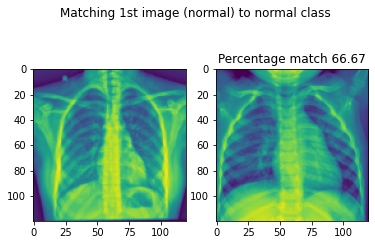

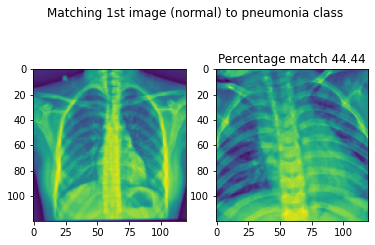

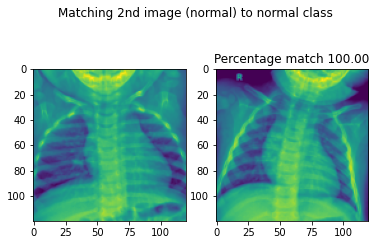

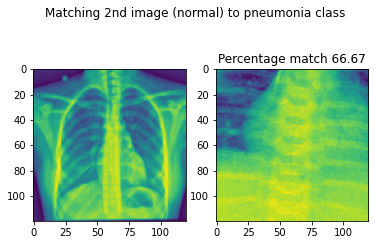

In [761]:
plt.suptitle("Matching 1st image (normal) to normal class")
plt.subplot(121)
plt.imshow(X[0].reshape(120,120))
plt.subplot(122)
plt.imshow(X[y==0][match_result_s1[0][0]].reshape(120,120))
plt.title(f"Percentage match {match_result_s1[0][1]:0.2f}")
plt.show()

plt.suptitle("Matching 1st image (normal) to pneumonia class")
plt.subplot(121)
plt.imshow(X[0].reshape(120,120))
plt.subplot(122)
plt.imshow(X[y==1][match_result_b[0][0]].reshape(120,120))
plt.title(f"Percentage match {match_result_b[0][1]:0.2f}")
plt.show()


plt.suptitle("Matching 2nd image (normal) to normal class")
plt.subplot(121)
plt.imshow(X[1].reshape(120,120))
plt.subplot(122)
plt.imshow(X[y==0][match_result_s1[1][0]].reshape(120,120))
plt.title(f"Percentage match {match_result_s1[1][1]:0.2f}")
plt.show()

plt.suptitle("Matching 2nd image (normal) to pneumonia class")
plt.subplot(121)
plt.imshow(X[0].reshape(120,120))
plt.subplot(122)
plt.imshow(X[y==1][match_result_b[1][0]].reshape(120,120))
plt.title(f"Percentage match {match_result_b[1][1]:0.2f}")
plt.show()

We can see the third row is showing 100% match in dasiy feature keypoint, and the images second image in the third row looks to be same picture just turned to one side compared to the first image. The last row does not looks like it matches any part of the first image.

Now for pneumonia images.

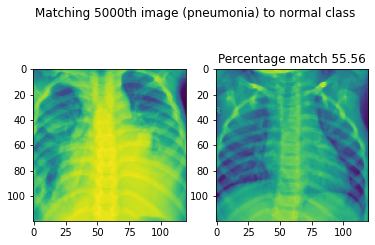

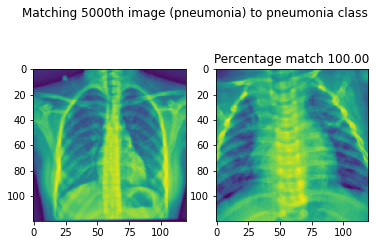

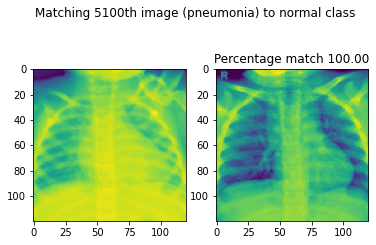

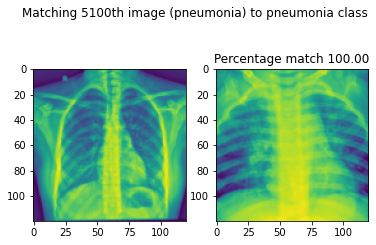

In [763]:
plt.suptitle("Matching 5000th image (pneumonia) to normal class")
plt.subplot(121)
plt.imshow(X[5000].reshape(120,120))
plt.subplot(122)
plt.imshow(X[y==0][match_result_s1[5000][0]].reshape(120,120))
plt.title(f"Percentage match {match_result_s1[5000][1]:0.2f}")
plt.show()

plt.suptitle("Matching 5000th image (pneumonia) to pneumonia class")
plt.subplot(121)
plt.imshow(X[0].reshape(120,120))
plt.subplot(122)
plt.imshow(X[y==1][match_result_b[5000][0]].reshape(120,120))
plt.title(f"Percentage match {match_result_b[5000][1]:0.2f}")
plt.show()

plt.suptitle("Matching 5100th image (pneumonia) to normal class")
plt.subplot(121)
plt.imshow(X[5100].reshape(120,120))
plt.subplot(122)
plt.imshow(X[y==0][match_result_s1[5100][0]].reshape(120,120))
plt.title(f"Percentage match {match_result_s1[5100][1]:0.2f}")
plt.show()

plt.suptitle("Matching 5100th image (pneumonia) to pneumonia class")
plt.subplot(121)
plt.imshow(X[0].reshape(120,120))
plt.subplot(122)
plt.imshow(X[y==1][match_result_b[5100][0]].reshape(120,120))
plt.title(f"Percentage match {match_result_b[5100][1]:0.2f}")
plt.show()

For matching the pneumonia images, we see bottom three are perfect match, the second image by eye does look like some transformation to the first images. This is doing better than the normal images. 

Due to the time constrain and limited computational capacity, running over all the images is not feasible at the moment.  

Here, I just wanted to use sobel filter in one of the images. Third image is with inverted color to second image.

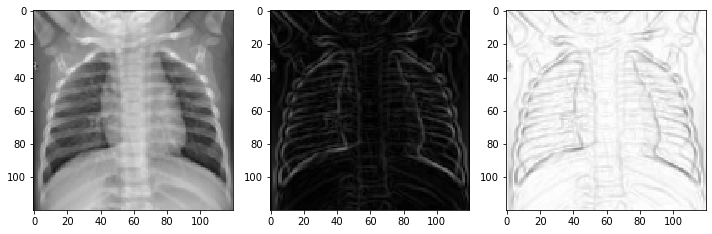

In [714]:
%matplotlib inline
from skimage.io import imshow
from skimage.filters import sobel_h, sobel_v
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
idx_to_reconstruct = int(np.random.rand(1)*len(X))
img  = X[idx_to_reconstruct].reshape((h,w))
imshow(img,cmap='gray')
plt.grid(False)

plt.subplot(1,3,2)
gradient_mag = np.sqrt(sobel_v(img)**2 + sobel_h(img)**2 ) 
imshow(gradient_mag,cmap='gray')
plt.grid(False)

plt.subplot(1,3,3)
gradient_mag = np.sqrt(sobel_v(img)**2 + sobel_h(img)**2 ) 
imshow(1-gradient_mag,cmap='gray')
plt.grid(False)
plt.show()

In [127]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from scipy import stats

# prepare filter bank kernels
kernels = []
for theta in range(8):# orientations
    theta = theta / 8. * np.pi
    for sigma in (1, 3, 5): # std
        for frequency in (0.05, 0.15, 0.25, 0.35): # frequency
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

            
# compute the filter bank and take statistics of image
# this can be drastically sped up using the 2D FFT
def compute_gabor(row, kernels, shape):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(row.reshape(shape), kernel, mode='wrap')
        _,_,feats[k,0],feats[k,1],feats[k,2],feats[k,3] = stats.describe(filtered.reshape(-1))
        # mean, var, skew, kurt
        
    return feats.reshape(-1)

idx_to_reconstruct = int(np.random.rand(1)*len(X))

gabr_feature = compute_gabor(X[idx_to_reconstruct], kernels, (h,w))
gabr_feature.shape

(384,)

Computational Limitation here, applying the gabor filer took 560 mins! The notebook restarted after running the following code so I am unable to do further testing on the gabor features mainly due to time constrants.  

In [129]:

# takes some time to run entire dataset (using lots of orientations, std, and frequency)
gabor_stats = np.apply_along_axis(compute_gabor, 1, X, kernels, (h,w))
print(gabor_stats.shape)

(5216, 384)


In [130]:
knn_gab = KNeighborsClassifier(n_neighbors=1)

gab_train, gab_test, y_train, y_test = train_test_split(
    gabor_stats,y,test_size=0.2, train_size=0.8)
knn_gab.fit(gab_train,y_train)
acc_gab = accuracy_score(knn_gab.predict(gab_test),y_test)

print(f"Gabor accuracy: {100*acc_gab:.2f}%")

Gabor accuracy: 80.27%


The Gabor Feature extractor is underperforming to other Feature extractor we have looked at, if we compare n_neighbors=1 and p=2. for example for the same parameters PCA's are in range of 92% accurate and Daisy's at 86% accuracy. 
In conclusion, PCA seems to be performing best as a feature extractor, however only few daisy architecture were test. For Daisy, having sparse initial rings (red dots) with wider radius seems to work best, further test can be conducted with fewer and further rings.   


# Citation

____
 1. Kermany, D. S., Goldbaum, M., Cai, W., Valentim, C. C., Liang, H., Baxter, S. L., . . . Zhang, K. (2018, February 22). Identifying medical diagnoses and treatable diseases by image-based Deep Learning. Cell, 172(5). doi:10.1016/j.cell.2018.02.010
 2. https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
 3. https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb 